<a href="https://colab.research.google.com/github/shivansh2310/Finance-Stuff/blob/main/End_Of_Month_Trading_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install yfinance

In [30]:
import numpy as np
import pandas as pd
import yfinance as yf

In [319]:
df = yf.download('DYFI').reset_index()

[*********************100%%**********************]  1 of 1 completed


In [320]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-01-10,25.020000,25.070000,25.010000,25.010000,25.010000,757900
1,2024-01-11,24.990000,25.139999,24.990000,25.139999,25.139999,83300
2,2024-01-12,25.170000,25.200001,25.100000,25.156000,25.156000,8800
3,2024-01-16,25.049000,25.070000,24.862000,24.905001,24.905001,12700
4,2024-01-17,24.950001,24.950001,24.840000,24.844999,24.844999,4400
5,2024-01-18,24.879999,24.879999,24.849001,24.850000,24.850000,1800
6,2024-01-19,24.822001,24.879999,24.822001,24.879999,24.879999,2400
7,2024-01-22,24.957001,24.980000,24.909000,24.920000,24.920000,1000
8,2024-01-23,24.865000,24.886999,24.865000,24.886999,24.886999,1100
9,2024-01-24,24.885000,24.885000,24.857000,24.857000,24.857000,1500


In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       11 non-null     datetime64[ns]
 1   Open       11 non-null     float64       
 2   High       11 non-null     float64       
 3   Low        11 non-null     float64       
 4   Close      11 non-null     float64       
 5   Adj Close  11 non-null     float64       
 6   Volume     11 non-null     int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 744.0 bytes


In [322]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

In [323]:
df['trading_day_month'] = df.groupby(['Year', 'Month']).cumcount() + 1

In [324]:
max_trading_day = (
    df
    .groupby(['Year', 'Month'])
    .agg({'trading_day_month': 'max'})
    .rename(columns={'trading_day_month': 'Max_trading_day_month'})
    .reset_index()
)

In [325]:
df = pd.merge(df, max_trading_day, on=['Year', 'Month'], how='left')

In [326]:
df['days_from_max_day'] = df['Max_trading_day_month'] - df['trading_day_month']

In [327]:
df['Signal'] = np.where((df['days_from_max_day'] < 7) & (df['days_from_max_day'] != 0), 1, 0)

In [328]:
df['pct_changes'] = df['Adj Close'].pct_change()
df['strat_percs'] = df['Signal'].shift(1)*df['pct_changes']

In [329]:
df = df.dropna()

In [330]:
df['buy_n_hold'] = np.cumprod(1+df['pct_changes'])
df['strat_equity'] = np.cumprod(1+df['strat_percs'])

<Axes: xlabel='Date'>

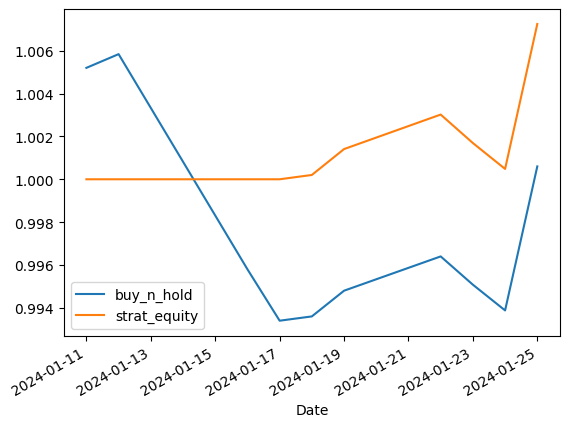

In [331]:
df.plot(x='Date', y=['buy_n_hold', 'strat_equity'])

In [332]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Line(x=df['Date'], y=df['buy_n_hold'], name='Buy N Hold'))
fig.add_trace(go.Line(x=df['Date'], y=df['strat_equity'], name='Strategy'))

fig.update_layout(
    title='TLT month end strategy',
    xaxis={'title':'Date'},
    yaxis={'title':'Multiple from intial investments'},
)

fig.show()

/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [333]:
def get_max_drawdown(col):
  drawdown = col/col.cummax()-1
  return 100*drawdown.min()

def sharpe_ratio(returns):
  return np.sqrt(252)*returns.mean()/returns.std()

def calc_cagr(col, n_years):
  cagr = (col.values[-1]/col.values[0])**(1/n_years) - 1
  return 100*cagr

print('Max Drawdown buy_n_hold: ', get_max_drawdown(df['buy_n_hold']))
print('Max Drawdown Strat: ', get_max_drawdown(df['strat_equity']))

print('Sharpe Ratio buy_n_hold: ', sharpe_ratio(df['pct_changes']))
print('Sharpe Ratio Strat: ', sharpe_ratio(df['strat_percs']))

n_years = (df['Date'].max()-df['Date'].min()).days/365.25
print('CAGR buy_n_hold: ', calc_cagr(df['buy_n_hold'], n_years))
print('CAGR Strat: ', calc_cagr(df['strat_equity'], n_years))



Max Drawdown buy_n_hold:  -1.2362888467038702
Max Drawdown Strat:  -0.25280788583034175
Sharpe Ratio buy_n_hold:  0.24205121937827562
Sharpe Ratio Strat:  4.99487887256913
CAGR buy_n_hold:  -11.273888084601957
CAGR Strat:  20.723625809482794
